In [ ]:
import os
import numpy as np
import pickle
import tensorflow
import tensorflow as tf
import pandas as pd
from collections import defaultdict
import string
import re
import pickle
import random
import zipfile
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, Add
from tensorflow.keras.optimizers import Adam
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint

In [ ]:
from PIL import Image
from IPython.display import display

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
'''Mounting drive
from google.colab import drive
drive.mount('/content/drive')'''

In [ ]:
zip_path = '/content/drive/MyDrive/DL_Set 4.zip'
extract_path = '/content/drive/MyDrive/DL_Set_4'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Unzipped dataset to:", extract_path)

Unzipped dataset to: /content/drive/MyDrive/DL_Set_4


# Setup Image Directory and Load Model

In [ ]:
image_dir = os.path.join(extract_path, 'Images')
image_files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

In [ ]:
print(image_files[:5])

['1000268201_693b08cb0e.jpg', '1001773457_577c3a7d70.jpg', '1002674143_1b742ab4b8.jpg', '1003163366_44323f5815.jpg', '1007129816_e794419615.jpg']


In [ ]:
len(image_files)

8091

# 1) Use VGG16, which is a pre-trained model on a million+ images and used to classify them into appropriate categories. There are also other pre-trained CNN models.

In [ ]:
# Load VGG16 without final classification layer
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


# 2) Use keras library and import VGG16 model and preprocess_input to extract image features

In [ ]:
def extract_features(image_path):
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = preprocess_input(image)
    features = model.predict(image, verbose=0)
    return features.flatten()

# 3) Extract features of each image and store in a dictionary format with image name (file name) as key and features of the image as values.

In [ ]:
features_dict = {}
for img_name in image_files:
    full_path = os.path.join(image_dir, img_name)
    try:
        features = extract_features(full_path)
        features_dict[img_name] = features
    except Exception as e:
        print(f"Error with {img_name}: {e}")

# 4) Save the features into a pickle file

In [ ]:
output_path = '/content/drive/MyDrive/Datasets_DL4/image_features.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(features_dict, f)
print("Saved features to:", output_path)

Saved features to: /content/drive/MyDrive/Datasets_DL4/image_features.pkl


In [ ]:
# Load the image features from file
with open('/content/drive/MyDrive/Datasets_DL4/image_features.pkl', 'rb') as f:
    features_dict = pickle.load(f)

In [ ]:
dictimg = list(features_dict.items())[:2]
print(dictimg)

[('1000268201_693b08cb0e.jpg', array([2.5074744, 0.       , 0.       , ..., 0.       , 0.       ,
       0.       ], dtype=float32)), ('1001773457_577c3a7d70.jpg', array([0.       , 0.       , 0.4941482, ..., 0.       , 0.       ,
       0.       ], dtype=float32))]


# 5) The captions.txt file contains multiple texts describing each image. It may happen that some image ids in the caption file do not have a corresponding image. Store them separately

In [ ]:
captions_path = '/content/drive/MyDrive/DL_Set_4/captions.txt'
image_folder = '/content/drive/MyDrive/DL_Set_4/Images'

In [ ]:
# Load caption file
df = pd.read_csv(captions_path)
# Get available image filenames
available_images = set(os.listdir(image_folder))

In [ ]:
# Check number of total rows (should be ~40,000 if each image has 5 captions)
print(f"Total rows in captions.txt: {len(df)}")
# Count unique image filenames
unique_images_in_captions = df['image'].nunique()
print(f"Unique image names in captions.txt: {unique_images_in_captions}")

Total rows in captions.txt: 40455
Unique image names in captions.txt: 8091


In [ ]:
print(f"Number of image files in Image folder: {len(available_images)}")
# Find how many from captions.txt are available in folder
image_ids_in_captions = set(df['image'].unique())
valid_images = image_ids_in_captions.intersection(available_images)
print(f"Images in both Image folder and captions.txt: {len(valid_images)}")

Number of image files in Image folder: 8091
Images in both Image folder and captions.txt: 8091


In [ ]:
# Find missing images
all_image_ids = set(df['image'])
missing_images = list(all_image_ids - available_images)
print(f"Missing images: {len(missing_images)}")

Missing images: 0


In [ ]:
'''
# Save missing images
with open('/content/drive/MyDrive/Datasets_DL4/missing_images.pkl', 'wb') as f:
    pickle.dump(missing_images, f)
print(f"Missing images: {len(missing_images)}")
'''

# 6) Create another dictionary and store image id as key and captions as value (list format)

In [ ]:
captions_dict = defaultdict(list)
for img, cap in zip(df['image'], df['caption']):
    if img not in missing_images:
        captions_dict[img].append(cap)
print(f"Usable image-caption pairs: {len(captions_dict)}")

Usable image-caption pairs: 8091


In [ ]:
captions_dict['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
for key, value in list(captions_dict.items())[:4]:
    print(key, value)

1000268201_693b08cb0e.jpg ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']
1001773457_577c3a7d70.jpg ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']
1002674143_1b742ab4b8.jpg ['A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .', 'A little girl is sitting in front of a large painted rainbow .', 'A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .', 'There is a girl with pigtails sitting

In [ ]:
print(list(captions_dict.items())[:2])

[('1000268201_693b08cb0e.jpg', ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']), ('1001773457_577c3a7d70.jpg', ['A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .'])]


# 7) Pre-process the text – remove numbers, punctuations and special characters, additional spaces

In [ ]:
def clean_caption(text):
    text = text.lower()
    text = re.sub(r'\d', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text
for img in captions_dict:
    captions_dict[img] = [clean_caption(cap) for cap in captions_dict[img]]

# 8) Add a tag for start of sequence and end of sequence to each caption

In [ ]:
for img in captions_dict:
    captions_dict[img] = [f"<start> {cap} <end>" for cap in captions_dict[img]]

# 9) Tokenize the words

In [ ]:
# Flatten all captions
all_captions = []
for captions in captions_dict.values():
    all_captions.extend(captions)
# Tokenize
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
# Save tokenizer
with open('/content/drive/MyDrive/Datasets_DL4/tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
print("Tokenizer saved. Vocabulary size:", vocab_size)

Tokenizer saved. Vocabulary size: 8779


In [ ]:
def is_caption_clean(caption):
    # Remove <start> and <end> before checking punctuation
    core_caption = caption.replace("<start>", "").replace("<end>", "").strip()
    if re.search(r'\d', caption): return False
    if any(char in string.punctuation for char in core_caption): return False
    if not caption.startswith("<start>") or not caption.endswith("<end>"): return False
    return True

In [ ]:
unclean = []
for img_id, caps in captions_dict.items():
    for cap in caps:
        if not is_caption_clean(cap):
            unclean.append((img_id, cap))
print(f"Unclean captions found: {len(unclean)}")

Unclean captions found: 0


In [ ]:
caption_counts = [len(caps) for caps in captions_dict.values()]
print(f"Min captions per image: {min(caption_counts)}")
print(f"Max captions per image: {max(caption_counts)}")
print(f"Average captions per image: {sum(caption_counts) / len(caption_counts):.2f}")

Min captions per image: 5
Max captions per image: 5
Average captions per image: 5.00


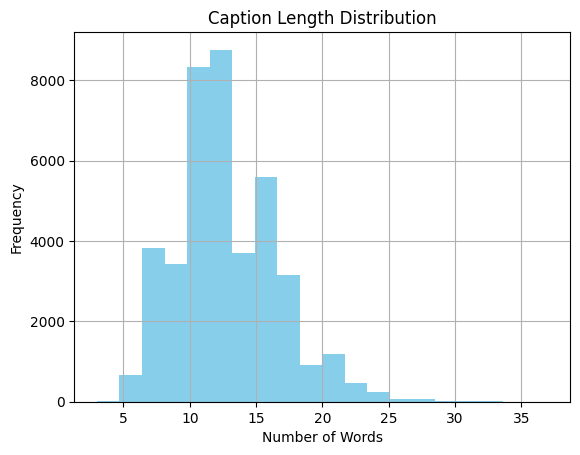

In [ ]:
caption_lengths = [len(cap.split()) for caps in captions_dict.values() for cap in caps]
plt.hist(caption_lengths, bins=20, color='skyblue')
plt.title("Caption Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [ ]:
# Get length of each caption
caption_lengths = [len(cap.split()) for cap in all_captions]
# Count frequency of each length
length_distribution = Counter(caption_lengths)
# Sort and display the distribution
for length in sorted(length_distribution):
    print(f"Length {length}: {length_distribution[length]} captions")

Length 3: 2 captions
Length 4: 25 captions
Length 5: 178 captions
Length 6: 475 captions
Length 7: 1176 captions
Length 8: 2651 captions
Length 9: 3419 captions
Length 10: 3912 captions
Length 11: 4425 captions
Length 12: 4567 captions
Length 13: 4195 captions
Length 14: 3714 captions
Length 15: 3082 captions
Length 16: 2510 captions
Length 17: 1776 captions
Length 18: 1367 captions
Length 19: 906 captions
Length 20: 706 captions
Length 21: 475 captions
Length 22: 282 captions
Length 23: 186 captions
Length 24: 137 captions
Length 25: 95 captions
Length 26: 65 captions
Length 27: 46 captions
Length 28: 26 captions
Length 29: 16 captions
Length 30: 12 captions
Length 31: 14 captions
Length 32: 5 captions
Length 33: 5 captions
Length 34: 1 captions
Length 35: 3 captions
Length 37: 1 captions


In [ ]:
all_words = [word for cap in all_captions for word in cap.split()]
word_freq = Counter(all_words)
print("Most common 10 words:", word_freq.most_common(20))

Most common 10 words: [('a', 62986), ('<start>', 40455), ('<end>', 40455), ('in', 18974), ('the', 18418), ('on', 10743), ('is', 9345), ('and', 8851), ('dog', 8136), ('with', 7765), ('man', 7265), ('of', 6713), ('two', 5638), ('white', 3940), ('black', 3832), ('boy', 3581), ('are', 3504), ('woman', 3402), ('girl', 3328), ('to', 3173)]


In [ ]:
# Load the tokenizer from file
with open('/content/drive/MyDrive/Datasets_DL4/tokenizer.pkl', 'rb') as f:
    tokenizer = pickle.load(f)

In [ ]:
print("Number of words in vocabulary:", len(tokenizer.word_index))

Number of words in vocabulary: 8778


In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)

Vocabulary size: 8779


In [ ]:
print(tokenizer)

In [ ]:
dff = pd.DataFrame(list(tokenizer.word_index.items()), columns=['word', 'index'])

In [ ]:
dff.shape

(8778, 2)

In [ ]:
dff.head()

,word,index
0,a,1
1,end,2
2,start,3
3,in,4
4,the,5


In [ ]:
dff.sort_values(by='index').head(10)

,word,index
0,a,1
1,end,2
2,start,3
3,in,4
4,the,5
5,on,6
6,is,7
7,and,8
8,dog,9
9,with,10


In [ ]:
tokenizer.word_index.get('dog')

9

In [ ]:
tokenizer.index_word[3]

'start'

In [ ]:
samp = tokenizer.texts_to_sequences(["<start> three people participate in rock climbing <end>"])

In [ ]:
print(samp)

[[3, 48, 23, 1460, 4, 84, 119, 2]]


In [ ]:
sample_captions = [
    "<start> a small dog jumping up to meet a yellow soccer ball <end>",
    "<start> a little boy and his father talking to a man dressed as santa claws <end>"
]
sequences = tokenizer.texts_to_sequences(sample_captions)
for caption, seq in zip(sample_captions, sequences):
    print(f"Caption: {caption}")
    print(f"Sequence: {seq}\n")

Caption: <start> a small dog jumping up to meet a yellow soccer ball <end>
Sequence: [3, 1, 52, 9, 45, 53, 20, 2068, 1, 59, 105, 39, 2]

Caption: <start> a little boy and his father talking to a man dressed as santa claws <end>
Sequence: [3, 1, 40, 16, 8, 29, 1141, 304, 20, 1, 11, 107, 78, 803, 7038, 2]



In [ ]:
# Find the longest caption length (in terms of number of words)
def get_max_length(captions_dict):
    all_captions = []
    for cap_list in captions_dict.values():
        all_captions.extend(cap_list)
    return max(len(caption.split()) for caption in all_captions)

In [ ]:
max_length = get_max_length(captions_dict)
print("Max caption length:", max_length)

Max caption length: 38


In [ ]:
import statistics
# Find the average caption length (in terms of number of words)
def get_average_length(captions_dict):
    all_captions = []
    for cap_list in captions_dict.values():
        all_captions.extend(cap_list)
    # Calculate the length of each caption and find the mean
    caption_lengths = [len(caption.split()) for caption in all_captions]
    return statistics.mean(caption_lengths)
average_length = get_average_length(captions_dict)
print("Average caption length:", average_length)

Average caption length: 11.78259794833766


# 10) Split data into train and test

In [ ]:
# Get all image IDs (image filenames with captions)
image_ids = list(captions_dict.keys())
# Split image IDs into 80% training and 20% testing
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

In [ ]:
image_ids[:5]

['1000268201_693b08cb0e.jpg',
 '1001773457_577c3a7d70.jpg',
 '1002674143_1b742ab4b8.jpg',
 '1003163366_44323f5815.jpg',
 '1007129816_e794419615.jpg']

In [ ]:
print(f"Total images: {len(image_ids)}")
print(f"Train images: {len(train_ids)}")
print(f"Test images: {len(test_ids)}")

Total images: 8091
Train images: 6472
Test images: 1619


# 11) Define a function to batch the data based on training set, feature and mapping dictionaries, tokenizer, vocabulary size and batch size.

In [ ]:
"""
    Generates input-output pairs for training:
    - X1: image features (from VGG16)
    - X2: input caption sequences
    - y: target words (one-hot encoded)
    """

In [ ]:
def data_generator(train_ids, captions_dict, features_dict, tokenizer, max_length, vocab_size, batch_size):
    while True:
        X1, X2, y = [], [], []
        n = 0
        for img_id in train_ids:
            captions = captions_dict[img_id]
            feature = features_dict[img_id]
            for caption in captions:
                # Convert caption to sequence of integers
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Create input-output pairs from the sequence
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='post')[0]
                    # One-hot encode output word
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # Store
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
                    # Yield batch when full
                    n += 1
                    if n == batch_size:
                        #yield ([np.array(X1), np.array(X2)], np.array(y))
                        yield (np.array(X1), np.array(X2)), np.array(y)
                        #yield ([image_features, caption_input_sequence], target_word_one_hot_vector)
                        X1, X2, y = [], [], []
                        n=0

# 12) Define an encoder-decoder model as below:
a.
Encoder:

i.Define two input layers – one each for the image features and captions

ii.Apply drop out for image features and feed to a dense layer. Let us term it as “feature output”

iii.The captions need to be fed into an embedding model to create word embeddings, apply drop out and fed to an LSTM to create encoder output. Let us term the output from LSTM as “captions output”

b.
Decoder:

i.Combine the “feature output” and “captions output” and feed them to dense layers to generate captions for the image

# 13) Use ReLU and Softmax; Adam optimizer; categorical cross entropy as loss function

In [ ]:
# Inputs
# Feature extractor (image input)
# Encoder: Image feature input
inputs1 = Input(shape=(4096,))      # Image feature vector from VGG16 (fc2 layer)
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# Sequence processor (text input)
# Encoder: Caption input
inputs2 = Input(shape=(max_length,)) # Caption input (sequence of token ids)
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256, use_cudnn=False)(se2)

# Decoder (combine features and caption)
decoder1 = Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Final model
model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
batch_size = 32
epochs = 60

In [ ]:
# Create data generator for training
train_generator = data_generator(train_ids, captions_dict, features_dict, tokenizer, max_length, vocab_size, batch_size)

In [ ]:
output_signature = (
    (tf.TensorSpec(shape=(None, 4096), dtype=tf.float32), # Shape None for batch size
     tf.TensorSpec(shape=(None, max_length), dtype=tf.int32)),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
)

In [ ]:
# Create a tf.data.Dataset from your generator with the explicit output signature
# This dataset will then be used by model.fit
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_ids, captions_dict, features_dict, tokenizer, max_length, vocab_size, batch_size),
    output_signature=output_signature
)

In [ ]:
# Note: You don't need to call .batch(batch_size) on train_dataset here
# because the data_generator already yields batches of size batch_size.

In [ ]:
# 5 captions per image, so multiply number of training images by 5
steps_per_epoch = len(train_ids) * 5 // batch_size
# Save the best model during training based on lowest loss
checkpoint = ModelCheckpoint('model.h5', monitor='loss', save_best_only=True, verbose=1)

In [ ]:
# Train the model and store history
history = model.fit(
    train_dataset, # Use the created tf.data.Dataset
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    callbacks=[checkpoint],
    verbose=1
)

Epoch 1/60
1010/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.1491 - loss: 5.7505
Epoch 1: loss improved from inf to 5.29346, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.1491 - loss: 5.7496
Epoch 2/60
1007/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2530 - loss: 4.6429
Epoch 2: loss improved from 5.29346 to 4.60948, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.2530 - loss: 4.6428
Epoch 3/60
1007/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2710 - loss: 4.3431
Epoch 3: loss improved from 4.60948 to 4.34034, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.2711 - loss: 4.3431
Epoch 4/60
1007/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2809 - loss: 4.2729
Epoch 4: loss improved from 4.34034 to 4.21084, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.2809 - loss: 4.2726
Epoch 5/60
1009/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2995 - loss: 4.1128
Epoch 5: loss improved from 4.21084 to 4.08514, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.2995 - loss: 4.1127
Epoch 6/60
1010/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3036 - loss: 4.0673
Epoch 6: loss improved from 4.08514 to 4.04206, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3036 - loss: 4.0672
Epoch 7/60
1009/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3048 - loss: 4.1148
Epoch 7: loss did not improve from 4.04206
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3048 - loss: 4.1146
Epoch 8/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3150 - loss: 4.0094
Epoch 8: loss improved from 4.04206 to 3.97168, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.3150 - loss: 4.0094
Epoch 9/60
1007/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3229 - loss: 3.8745
Epoch 9: loss improved from 3.97168 to 3.93674, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.3229 - loss: 3.8748
Epoch 10/60
1009/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3297 - loss: 3.8072
Epoch 10: loss improved from 3.93674 to 3.83105, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.3297 - loss: 3.8072
Epoch 11/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3299 - loss: 3.8265
Epoch 11: loss did not improve from 3.83105
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3299 - loss: 3.8266
Epoch 12/60
1008/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3214 - loss: 3.8629
Epoch 12: loss improved from 3.83105 to 3.80741, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3215 - loss: 3.8627
Epoch 13/60
1009/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3269 - loss: 3.7905
Epoch 13: loss improved from 3.80741 to 3.74131, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3269 - loss: 3.7903
Epoch 14/60
1007/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3246 - loss: 3.6297
Epoch 14: loss improved from 3.74131 to 3.62668, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3246 - loss: 3.6296
Epoch 15/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3271 - loss: 3.5696
Epoch 15: loss improved from 3.62668 to 3.58525, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3271 - loss: 3.5696
Epoch 16/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3313 - loss: 3.5790
Epoch 16: loss improved from 3.58525 to 3.53316, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3313 - loss: 3.5789
Epoch 17/60
1010/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3387 - loss: 3.5301
Epoch 17: loss improved from 3.53316 to 3.51572, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3387 - loss: 3.5301
Epoch 18/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3389 - loss: 3.5100
Epoch 18: loss did not improve from 3.51572
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3389 - loss: 3.5100
Epoch 19/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3370 - loss: 3.5819
Epoch 19: loss did not improve from 3.51572
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3370 - loss: 3.5819
Epoch 20/60
1010/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3413 - loss: 3.4805
Epoch 20: loss improved from 3.51572 to 3.46917, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3413 - loss: 3.4805
Epoch 21/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3393 - loss: 3.5172
Epoch 21: loss did not improve from 3.46917
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3393 - loss: 3.5171
Epoch 22/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3440 - loss: 3.4106
Epoch 22: loss improved from 3.46917 to 3.42064, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3440 - loss: 3.4106
Epoch 23/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3418 - loss: 3.5465
Epoch 23: loss did not improve from 3.42064
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3418 - loss: 3.5465
Epoch 24/60
1009/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3481 - loss: 3.4672
Epoch 24: loss did not improve from 3.42064
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3480 - loss: 3.4673
Epoch 25/60
1008/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3477 - loss: 3.4855
Epoch 25: loss did not improve from 3.42064
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3477 - loss: 3.4854
Epoch 26/60
1009/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3408 - loss: 3.4672
Epoch 26: loss did not improve from 3.42064
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3408 - loss: 3.4671
Epoch 27/60
1009/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0

1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3458 - loss: 3.4133
Epoch 28/60
1010/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3466 - loss: 3.3660
Epoch 28: loss improved from 3.40542 to 3.35707, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3466 - loss: 3.3660
Epoch 29/60
1010/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3508 - loss: 3.3174
Epoch 29: loss improved from 3.35707 to 3.32068, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3508 - loss: 3.3174
Epoch 30/60
1007/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3541 - loss: 3.3646
Epoch 30: loss did not improve from 3.32068
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3541 - loss: 3.3646
Epoch 31/60
1009/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3447 - loss: 3.4086
Epoch 31: loss did not improve from 3.32068
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3447 - loss: 3.4085
Epoch 32/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3479 - loss: 3.3342
Epoch 32: loss improved from 3.32068 to 3.31598, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3479 - loss: 3.3341
Epoch 33/60
1007/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3503 - loss: 3.3913
Epoch 33: loss did not improve from 3.31598
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3504 - loss: 3.3911
Epoch 34/60
1010/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3495 - loss: 3.3151
Epoch 34: loss improved from 3.31598 to 3.30958, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.3495 - loss: 3.3151
Epoch 35/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3583 - loss: 3.3005
Epoch 35: loss did not improve from 3.30958
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3583 - loss: 3.3006
Epoch 36/60
1009/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3584 - loss: 3.2713
Epoch 36: loss did not improve from 3.30958
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3584 - loss: 3.2715
Epoch 37/60
1008/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3589 - loss: 3.2773
Epoch 37: loss improved from 3.30958 to 3.29234, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.3589 - loss: 3.2773
Epoch 38/60
1009/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3514 - loss: 3.3194
Epoch 38: loss improved from 3.29234 to 3.26715, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3514 - loss: 3.3192
Epoch 39/60
1009/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3451 - loss: 3.3064
Epoch 39: loss did not improve from 3.26715
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3451 - loss: 3.3064
Epoch 40/60
1009/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3592 - loss: 3.2454
Epoch 40: loss improved from 3.26715 to 3.24163, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3592 - loss: 3.2454
Epoch 41/60
1009/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3611 - loss: 3.2096
Epoch 41: loss did not improve from 3.24163
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3611 - loss: 3.2097
Epoch 42/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3599 - loss: 3.2171
Epoch 42: loss did not improve from 3.24163
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3599 - loss: 3.2172
Epoch 43/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3623 - loss: 3.2685
Epoch 43: loss did not improve from 3.24163
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3622 - loss: 3.2685
Epoch 44/60
1009/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3550 - loss: 3.2537
Epoch 44: loss improved from 3.24163 to 3.23983, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3550 - loss: 3.2537
Epoch 45/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3563 - loss: 3.2776
Epoch 45: loss did not improve from 3.23983
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3563 - loss: 3.2776
Epoch 46/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3603 - loss: 3.1825
Epoch 46: loss improved from 3.23983 to 3.20119, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.3603 - loss: 3.1825
Epoch 47/60
1008/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3603 - loss: 3.3057
Epoch 47: loss did not improve from 3.20119
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3603 - loss: 3.3056
Epoch 48/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3612 - loss: 3.2264
Epoch 48: loss did not improve from 3.20119
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3612 - loss: 3.2264
Epoch 49/60
1008/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3642 - loss: 3.2167
Epoch 49: loss did not improve from 3.20119
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3642 - loss: 3.2168
Epoch 50/60
1007/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3671 - loss: 3.1609
Epoch 50: loss improved from 3.20119 to 3.17835, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3671 - loss: 3.1610
Epoch 51/60
1010/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3570 - loss: 3.2705
Epoch 51: loss did not improve from 3.17835
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3570 - loss: 3.2705
Epoch 52/60
1009/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3735 - loss: 3.1261
Epoch 52: loss improved from 3.17835 to 3.15529, saving model to model.h5


1011/1011 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - accuracy: 0.3735 - loss: 3.1262
Epoch 53/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3654 - loss: 3.1971
Epoch 53: loss did not improve from 3.15529
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3654 - loss: 3.1971
Epoch 54/60
1007/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3642 - loss: 3.2180
Epoch 54: loss did not improve from 3.15529
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3642 - loss: 3.2180
Epoch 55/60
1007/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3631 - loss: 3.2204
Epoch 55: loss did not improve from 3.15529
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3631 - loss: 3.2204
Epoch 56/60
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3709 - loss: 3.1448
Epoch 56: loss did not improve from 3.15529
1011/1011 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.3709 - loss: 3.1449
Epoch 57/60
1010/1011 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0

In [ ]:
# Print training loss and accuracy for each epoch
for i in range(len(history.history['loss'])):
    print(f"Epoch {i+1}/{epochs} - "
          f"Loss: {history.history['loss'][i]:.4f} - "
          f"Accuracy: {history.history.get('accuracy', [None]*epochs)[i]:.4f}")

Epoch 1/30 - Loss: 5.8142 - Accuracy: 0.1222
Epoch 2/30 - Loss: 4.9895 - Accuracy: 0.1803
Epoch 3/30 - Loss: 4.7076 - Accuracy: 0.2069
Epoch 4/30 - Loss: 4.4609 - Accuracy: 0.2302
Epoch 5/30 - Loss: 4.3722 - Accuracy: 0.2386
Epoch 6/30 - Loss: 4.3498 - Accuracy: 0.2455
Epoch 7/30 - Loss: 4.1996 - Accuracy: 0.2531
Epoch 8/30 - Loss: 4.1769 - Accuracy: 0.2570
Epoch 9/30 - Loss: 4.0515 - Accuracy: 0.2660
Epoch 10/30 - Loss: 4.0446 - Accuracy: 0.2638
Epoch 11/30 - Loss: 3.8781 - Accuracy: 0.2703
Epoch 12/30 - Loss: 3.7811 - Accuracy: 0.2760
Epoch 13/30 - Loss: 3.7631 - Accuracy: 0.2757
Epoch 14/30 - Loss: 3.6715 - Accuracy: 0.2871
Epoch 15/30 - Loss: 3.6409 - Accuracy: 0.2834
Epoch 16/30 - Loss: 3.6891 - Accuracy: 0.2838
Epoch 17/30 - Loss: 3.6100 - Accuracy: 0.2920
Epoch 18/30 - Loss: 3.5867 - Accuracy: 0.2918
Epoch 19/30 - Loss: 3.5925 - Accuracy: 0.2948
Epoch 20/30 - Loss: 3.5633 - Accuracy: 0.2964
Epoch 21/30 - Loss: 3.5258 - Accuracy: 0.2942
Epoch 22/30 - Loss: 3.4572 - Accuracy: 0.29

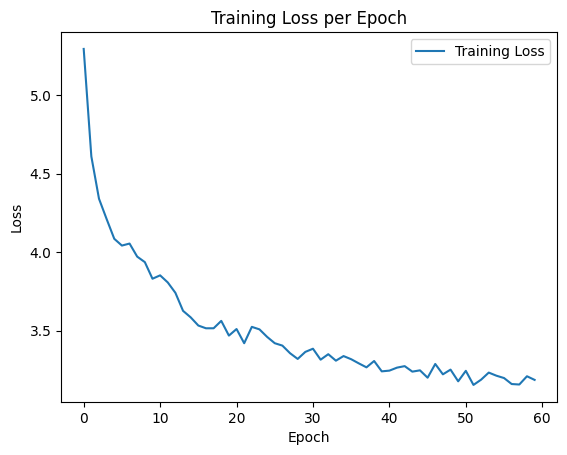

In [ ]:
# Plot training loss
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

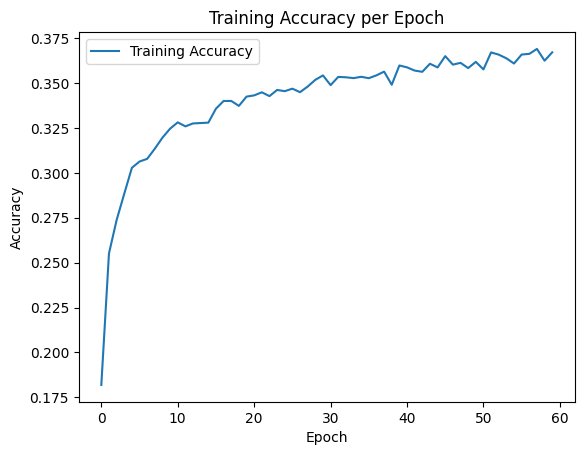

In [ ]:
# Plot training accuracy
if 'accuracy' in history.history:
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.title('Training Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [ ]:
try:
    model.load_weights('model.h5')
    print("Loaded model weights from model.h5")
except Exception as e:
    print(f"Error loading model weights: {e}")
    print("Proceeding with the current model state (from the last training epoch).")

Loaded model weights from model.h5


In [ ]:
model_save_path = '/content/drive/MyDrive/Datasets_DL4/image_captioning_model.h5'

In [ ]:
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/Datasets_DL4/image_captioning_model.h5


In [ ]:
"""
    Generates a caption for a single image feature vector.

    Args:
        model: The trained caption generation model.
        tokenizer: The tokenizer used for the captions.
        photo: The image feature vector (numpy array of shape (1, 4096)).
        max_length: The maximum sequence length used during training.

    Returns:
        A string containing the generated caption without start/end tokens.
"""

In [ ]:
# Function to generate caption for a given image feature
def generate_caption(model, tokenizer, photo, max_length):
    # Start with the start token
    in_text = '<start>'
    # Iterate over the max length to generate tokens one by one
    for _ in range(max_length):
        # Convert the current input text to sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence to the max_length
        sequence = pad_sequences([sequence], maxlen=max_length)
        # Predict the next word
        # The model expects a list of inputs: [image_features, caption_sequence]
        yhat = model.predict([photo, sequence], verbose=0)
        # Get the index of the word with the highest probability
        yhat = np.argmax(yhat)
        # Convert the index back to a word
        word = tokenizer.index_word.get(yhat)
        # Stop if the word is None (unknown) or the end token
        if word is None or word == '<end>':
            break
        # Append the predicted word to the input text
        in_text += ' ' + word
    # Return the generated caption, removing the start token
    return in_text.replace('<start>', '').strip()

In [ ]:
# --- Evaluate on Test Set ---
# Select the test image IDs (this is already available from your train_test_split)
# test_ids = ... (already defined)

In [ ]:
# Prepare references and hypotheses for BLEU calculation
actual, predicted = [], []
# Evaluate on all test images or a subset (e.g., test_ids[:100])
print(f"Evaluating on {len(test_ids)} test images")

Evaluating on 1619 test images


In [ ]:
for img_id in test_ids:
    # Get the image feature for the current test image
    photo = features_dict[img_id].reshape((1, 4096)) # Reshape for model input
    # Get the actual reference captions for this image
    # Remove start and end tokens for BLEU calculation
    ref_captions = [cap.replace('<start>', '').replace('<end>', '').strip() for cap in captions_dict[img_id]]
    # Generate a caption using the trained model
    generated_caption = generate_caption(model, tokenizer, photo, max_length)
    # Append references and the generated caption (split into words)
    # actual is a list of lists of words (each inner list is one reference caption)
    actual.append([ref.split() for ref in ref_captions])
    # predicted is a list of lists of words (each inner list is one generated caption)
    predicted.append(generated_caption.split())
print("Finished generating captions for test images.")

KeyboardInterrupt: 

In [ ]:
# Calculate and print corpus-level BLEU scores
# corpus_bleu compares a list of reference sets to a list of hypothesis lists
print("\nCorpus BLEU Scores:")
# BLEU-1 (unigrams)
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
# BLEU-2 (bigrams)
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
# BLEU-3 (trigrams)
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
# BLEU-4 (4-grams)
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))


Corpus BLEU Scores:


ZeroDivisionError: Fraction(0, 0)

In [ ]:
print("\nDisplaying some example predictions:")
# Get image directory path
image_dir_path = '/content/drive/MyDrive/DL_Set_4/Images' # Use the extract_path from your setup


Displaying some example predictions:


In [ ]:
def show_image_and_caption(image_path, actual_captions, generated_caption):
    """
    Displays an image along with its actual and generated captions.
    """
    try:
        image = Image.open(image_path)
        plt.figure(figsize=(10, 6))
        plt.imshow(image)
        plt.axis('off')
        plt.title("Generated: " + generated_caption)
        plt.text(0, -20, "Actual: " + '\n'.join(actual_captions), wrap=True)
        plt.show()
    except FileNotFoundError:
        print(f"Image file not found at {image_path}")
    except Exception as e:
        print(f"Error displaying image {image_path}: {e}")

In [ ]:
# Select a few random test images to display
display_image_ids = random.sample(test_ids, 5) # Choose 5 random images

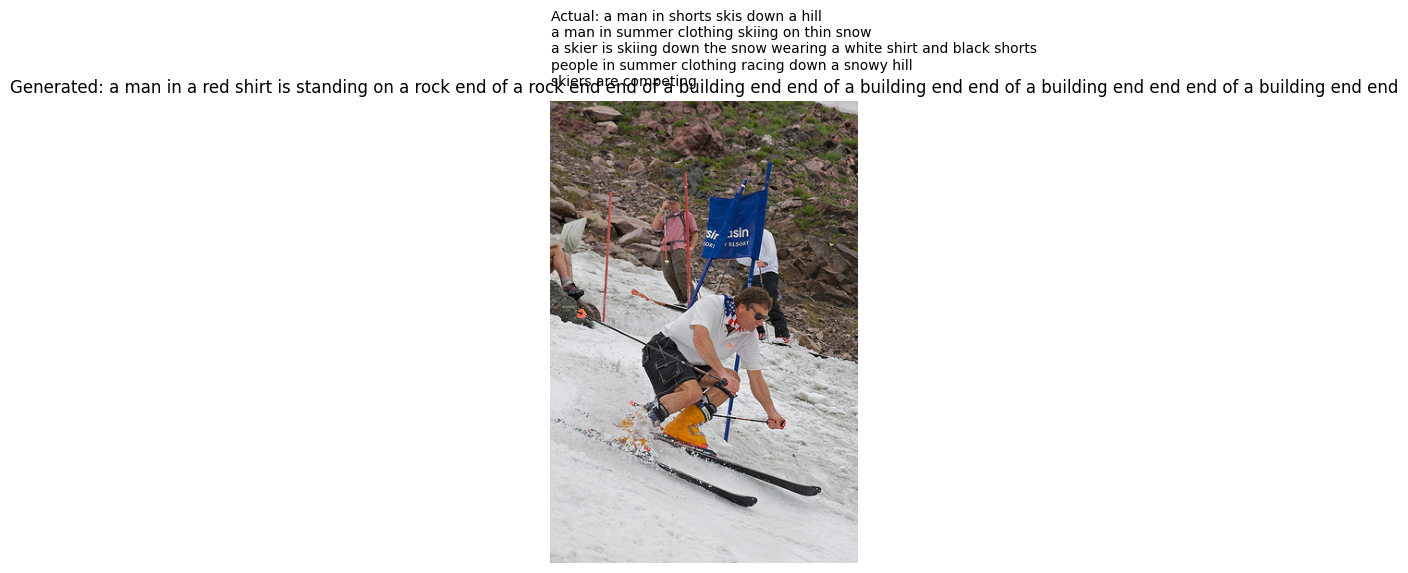

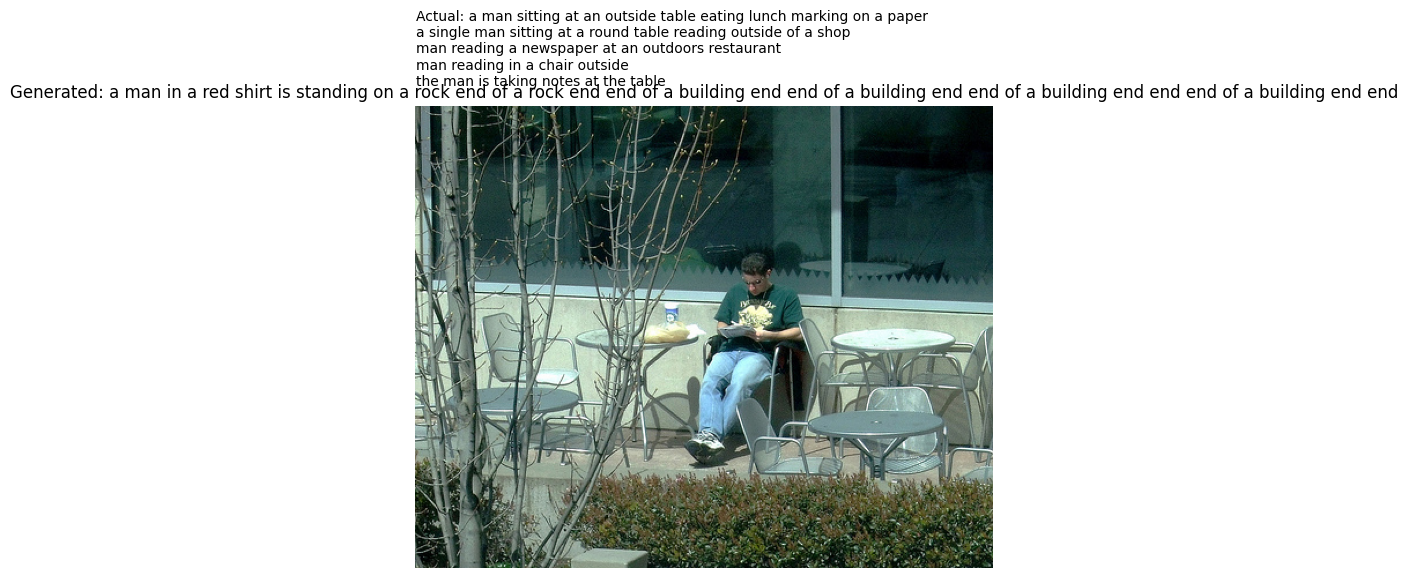

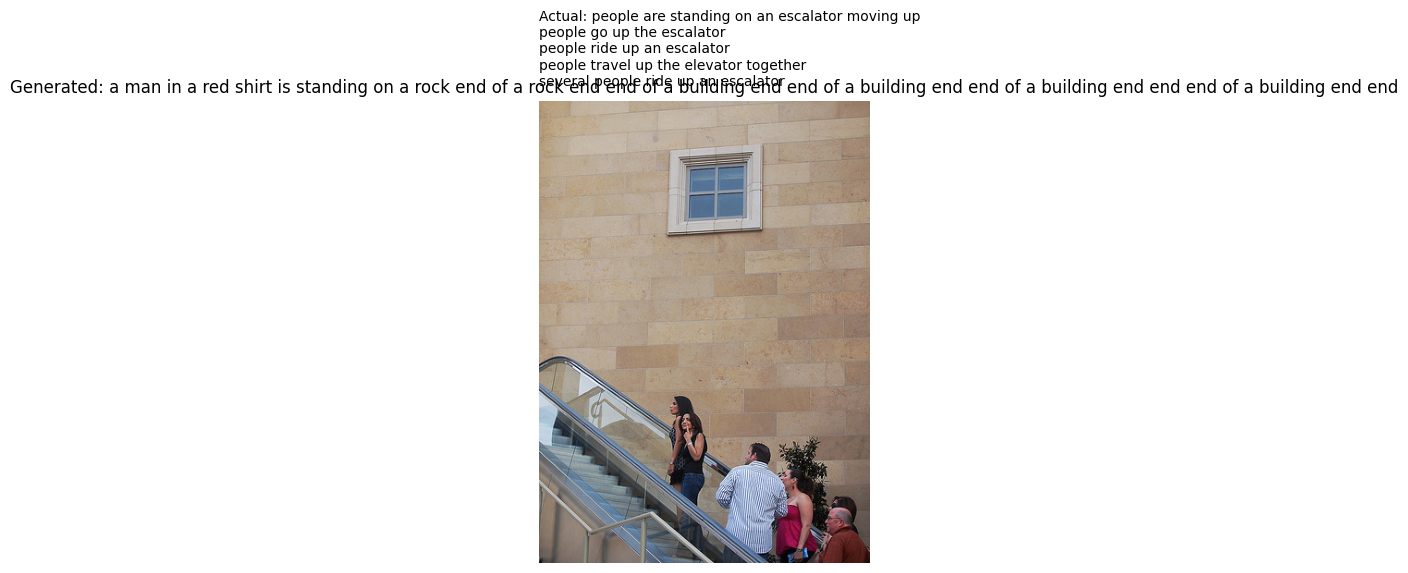

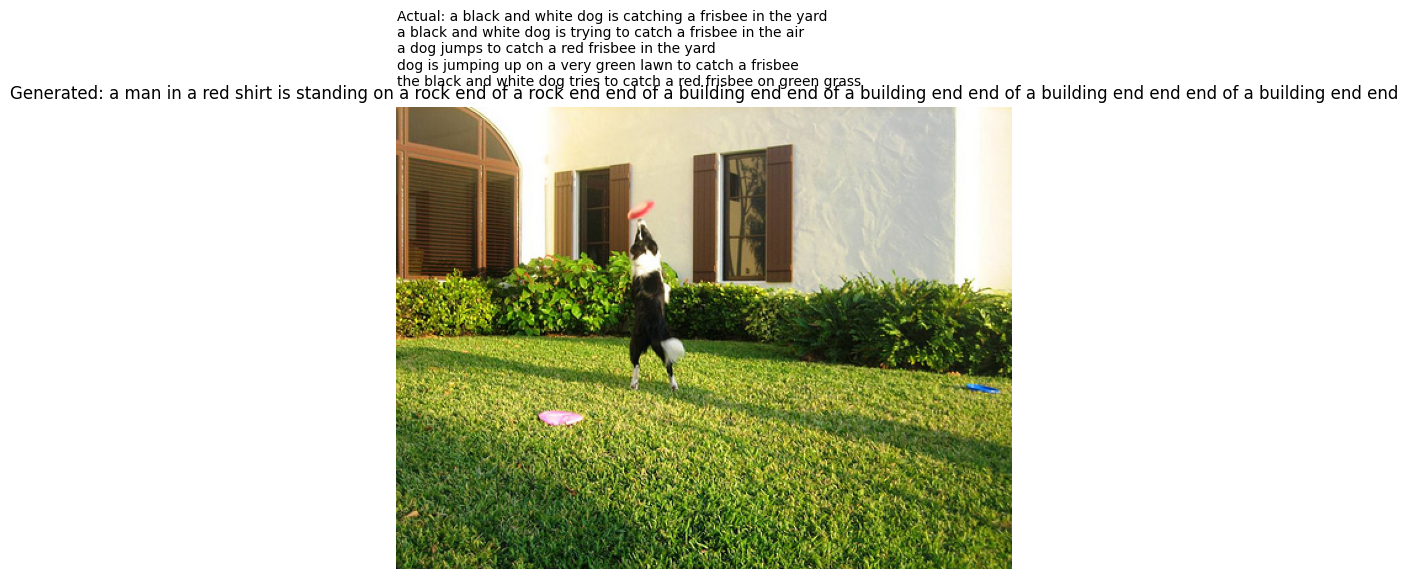

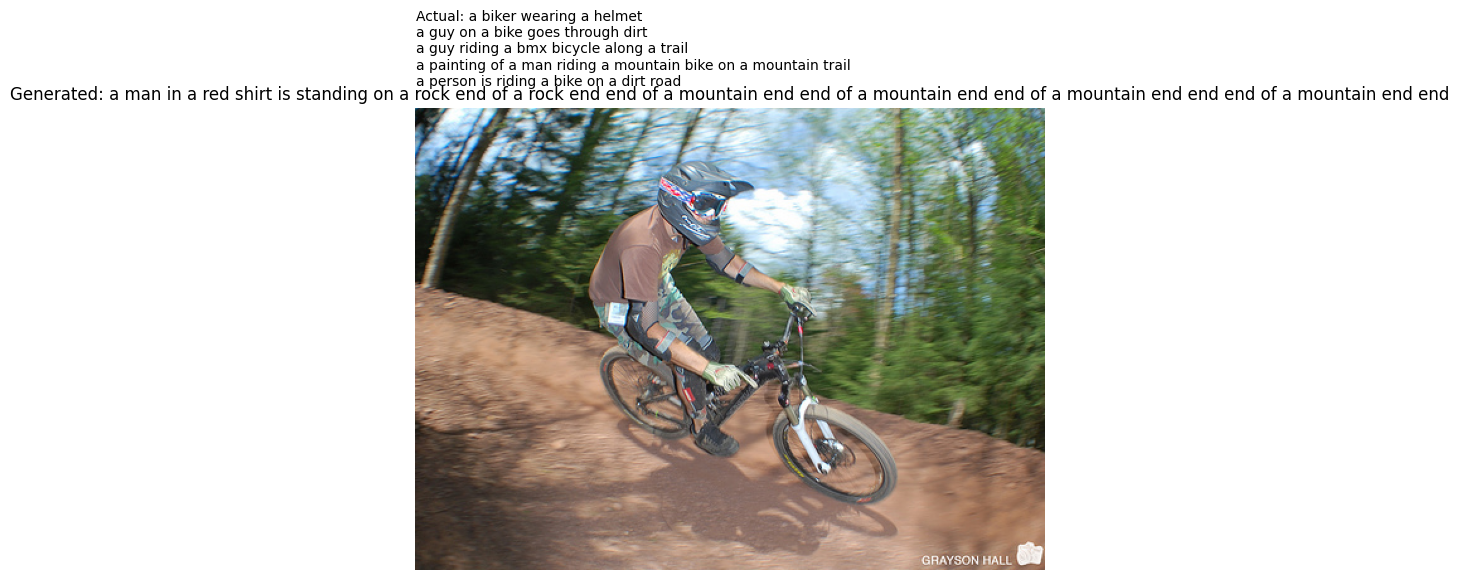

In [ ]:
for img_id in display_image_ids:
    full_image_path = os.path.join(image_dir_path, img_id)
    photo_feature = features_dict[img_id].reshape((1, 4096))
    ref_captions_display = [cap.replace('<start>', '').replace('<end>', '').strip() for cap in captions_dict[img_id]]
    generated_caption = generate_caption(model, tokenizer, photo_feature, max_length)
    show_image_and_caption(full_image_path, ref_captions_display, generated_caption)

In [ ]:
# --- Training Accuracy ---
# The training accuracy was already printed epoch by epoch during model.fit
# You can re-print the final training accuracy like this:
if 'accuracy' in history.history:
    final_train_accuracy = history.history['accuracy'][-1]
    print(f"\nFinal Training Accuracy: {final_train_accuracy:.4f}")
else:
     print("\nTraining accuracy metric was not recorded.")
# The plot of training accuracy was also already generated.
# If you need to display it again, you can re-run the plotting cell.


Final Training Accuracy: 0.3671


In [ ]:
# Function to generate caption
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text

In [ ]:
# Prepare references and hypotheses
actual, predicted = [], []
for img_id in test_ids[:100]:  # Use 100 test images for evaluation
    photo = features_dict[img_id].reshape((1, 4096))
    y_pred = generate_caption(model, tokenizer, photo, max_length)
    references = [cap.split() for cap in captions_dict[img_id]]
    actual.append(references)
    predicted.append(y_pred.split())

In [ ]:
# Print BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-1: 0.158421
BLEU-2: 0.093916
BLEU-3: 0.049065
BLEU-4: 0.023558


In [ ]:
# Print BLEU scores
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0, 1.0, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0, 0, 1.0, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0, 0, 0, 1.0)))

BLEU-1: 0.158421
BLEU-2: 0.055676
BLEU-3: 0.012222
BLEU-4: 0.002857


In [ ]:
import re
import string

def is_clean(caption):
    # Check for numbers
    '''if re.search(r'\d', caption):
        return False'''
    # Check for punctuation
    """if any(p in caption for p in string.punctuation):
        return False"""
    # Check for missing <start> or <end>
    if not caption.startswith('<start>') or not caption.endswith('<end>'):
        return False
    return True

In [ ]:
# Check for any unclean captions
unclean_captions = []
for img, caps in captions_dict.items():
    for cap in caps:
        if not is_clean(cap):
            unclean_captions.append(cap)
print(f"Unclean captions found: {len(unclean_captions)}")

Unclean captions found: 40455


In [ ]:
print(all_captions[:5])

['<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>', '<start> a girl going into a wooden building <end>', '<start> a little girl climbing into a wooden playhouse <end>', '<start> a little girl climbing the stairs to her playhouse <end>', '<start> a little girl in a pink dress going into a wooden cabin <end>']


In [ ]:
# Check for any unclean captions
unclean_captions = []
for caps in all_captions:
        if not is_clean(caps):
            unclean_captions.append(caps)
print(f"Unclean captions found: {len(unclean_captions)}")

Unclean captions found: 0


In [ ]:
from collections import Counter

caption_counts = [len(caps) for caps in captions_dict.values()]
print(f"Min captions per image: {min(caption_counts)}")
print(f"Max captions per image: {max(caption_counts)}")
print(f"Average captions per image: {sum(caption_counts)/len(caption_counts):.2f}")

Min captions per image: 5
Max captions per image: 5
Average captions per image: 5.00


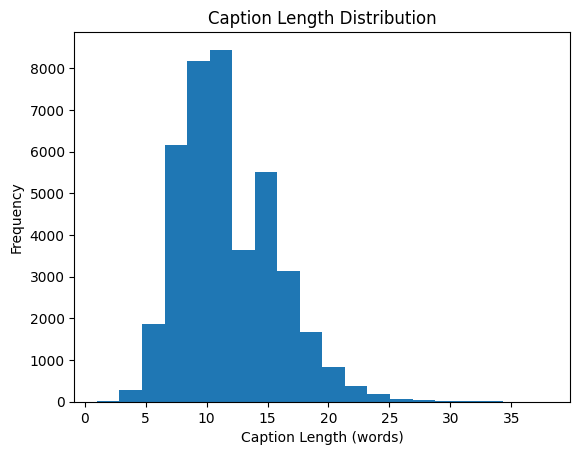

In [ ]:
import matplotlib.pyplot as plt

caption_lengths = [len(cap.split()) for caps in captions_dict.values() for cap in caps]
plt.hist(caption_lengths, bins=20)
plt.title("Caption Length Distribution")
plt.xlabel("Caption Length (words)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
from collections import Counter

all_tokens = []
for caps in captions_dict.values():
    for cap in caps:
        all_tokens.extend(cap.split())

word_freq = Counter(all_tokens)
print("Most common 10 words:", word_freq.most_common(10))

Most common 10 words: [('a', 40319), ('.', 36577), ('A', 22667), ('in', 18962), ('the', 15328), ('on', 10730), ('is', 9345), ('and', 8850), ('dog', 7984), ('with', 7760)]
